In [ ]:
# =====================================
# SAFE GOOGLE DRIVE MOUNT (Colab)
# =====================================
import os
from google.colab import drive

# Step 1: Unmount if already mounted
try:
    drive.flush_and_unmount()
    print("✅ Drive unmounted (if it was mounted).")
except:
    print("ℹ️ No existing mount found, continuing...")

# Step 2: Clean mountpoint
!rm -rf /content/drive

# Step 3: Mount again
drive.mount('/content/drive', force_remount=True)

# Step 4: Verify dataset path
DATASET_PATH = "/content/drive/MyDrive/AI_TRACEFINDER_DS"
if os.path.exists(DATASET_PATH):
    print(f"✅ Dataset folder found at: {DATASET_PATH}")
else:
    print(f"⚠️ Dataset folder not found! Check if 'AI_Tracefinder' exists inside your MyDrive.")


✅ Drive unmounted (if it was mounted).
Mounted at /content/drive
✅ Dataset folder found at: /content/drive/MyDrive/AI_TRACEFINDER_DS


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


                                        Preprocessing on Official and Wikipedia

In [ ]:

import os, cv2, numpy as np, pickle
from tqdm import tqdm
import pywt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Paths
OFFICIAL_DIR = "/content/drive/MyDrive/AI_TRACEFINDER_DS/Official"
WIKI_DIR = "/content/drive/MyDrive/AI_TRACEFINDER_DS/Wikipedia"
OUT_PATH = "/content/drive/MyDrive/AI_TRACEFINDER_DS/official_wiki_residuals.pkl"

# ---------------------------
# Preprocessing helpers
# ---------------------------
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

def resize_to(img, size=(256,256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    return img.astype(np.float32) / 255.0

def denoise_wavelet(img):
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
    # Zero out detail coefficients for denoising
    cH[:] = 0; cV[:] = 0; cD[:] = 0
    return pywt.idwt2((cA,(cH,cV,cD)), 'haar')

def compute_residual(img):
    denoised = denoise_wavelet(img)
    return img - denoised

def process_single_image(fpath):
    """Preprocess one image and return residual"""
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    if img is None:
        return None
    gray = to_gray(img)
    gray = resize_to(gray, (256,256))
    gray = normalize_img(gray)
    return compute_residual(gray)

# ---------------------------
# Dataset Processing
# ---------------------------
def process_dataset(base_dir, dataset_name, residuals_dict):
    print(f"🔄 Preprocessing {dataset_name} images...")

    for scanner in tqdm(os.listdir(base_dir)):
        scanner_path = os.path.join(base_dir, scanner)
        if not os.path.isdir(scanner_path):
            continue

        residuals_dict[dataset_name][scanner] = {}

        for dpi in os.listdir(scanner_path):   # 150, 300
            dpi_path = os.path.join(scanner_path, dpi)
            if not os.path.isdir(dpi_path):
                continue

            files = [os.path.join(dpi_path, f) for f in os.listdir(dpi_path)
                     if f.lower().endswith(('.tif','.tiff','.jpg','.jpeg','.png'))]

            dpi_residuals = []
            # Parallel processing
            with ThreadPoolExecutor(max_workers=8) as executor:  # adjust workers based on Colab
                futures = [executor.submit(process_single_image, f) for f in files]
                for fut in as_completed(futures):
                    res = fut.result()
                    if res is not None:
                        dpi_residuals.append(res)

            residuals_dict[dataset_name][scanner][dpi] = dpi_residuals

# ---------------------------
# Main Execution
# ---------------------------
residuals_dict = {"Official": {}, "Wikipedia": {}}

process_dataset(OFFICIAL_DIR, "Official", residuals_dict)
process_dataset(WIKI_DIR, "Wikipedia", residuals_dict)

with open(OUT_PATH, "wb") as f:
    pickle.dump(residuals_dict, f)

print(f"✅ Saved Official+Wiki residuals (150 & 300 separately) to {OUT_PATH}")


🔄 Preprocessing Official images...


100%|██████████| 11/11 [12:03<00:00, 65.81s/it]


🔄 Preprocessing Wikipedia images...


100%|██████████| 11/11 [16:06<00:00, 87.90s/it]


✅ Saved Official+Wiki residuals (150 & 300 separately) to /content/drive/MyDrive/AI_TRACEFINDER_DS/official_wiki_residuals.pkl


                                                      Preprocessing on Flatfield

In [ ]:


# 0) Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, pickle, cv2, numpy as np
from tqdm import tqdm

# ---------------------------
# 1) Auto-locate Flatfield folder
# ---------------------------
def find_flatfield(base="/content/drive/MyDrive/AI_TRACEFINDER_DS"):
    found = []
    for root, dirs, files in os.walk(base):
        for d in dirs:
            if d.lower() == "flatfield":   # case-insensitive search
                found.append(os.path.join(root, d))
    return found

flatfield_paths = find_flatfield("/content/drive/MyDrive/AI_TRACEFINDER_DS")
if not flatfield_paths:
    raise FileNotFoundError("❌ No 'Flatfield' folder found in your Drive. Please check dataset upload.")
else:
    FLATFIELD_DIR = flatfield_paths[0]  # take the first match
    BASE = os.path.dirname(FLATFIELD_DIR)
    OUTPUT_PKL = os.path.join(BASE, "flatfield_residuals.pkl")
    print("✅ Found Flatfield folder:", FLATFIELD_DIR)
    print("Will save residuals to:", OUTPUT_PKL)

# ---------------------------
# 2) Import denoising filters
# ---------------------------
try:
    from skimage.restoration import denoise_wavelet
except Exception:
    !pip install scikit-image
    from skimage.restoration import denoise_wavelet

from scipy.signal import wiener as scipy_wiener

# ---------------------------
# 3) Parameters
# ---------------------------
IMG_SIZE = (256, 256)      # resize target
DENOISE_METHOD = "wavelet"  # "wiener" or "wavelet"

# ---------------------------
# 4) Preprocess function
# ---------------------------
def preprocess_image_residual(path, img_size=IMG_SIZE, method="wiener"):
    """Read image -> grayscale -> resize -> normalize -> denoise -> return residual."""
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    if method == "wiener":
        den = scipy_wiener(img, mysize=(5,5))
    else:
        den = denoise_wavelet(img, channel_axis=None, rescale_sigma=True)
    return (img - den).astype(np.float32)

# ---------------------------
# 5) Process all Flatfield images
# ---------------------------
flatfield_residuals = {}
scanners = sorted(os.listdir(FLATFIELD_DIR))

for scanner in tqdm(scanners, desc="Scanners"):
    scanner_dir = os.path.join(FLATFIELD_DIR, scanner)
    if not os.path.isdir(scanner_dir):
        continue

    residuals = []
    for fname in sorted(os.listdir(scanner_dir)):
        if fname.startswith("._"):
            continue
        if not fname.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg")):
            continue
        fpath = os.path.join(scanner_dir, fname)
        try:
            res = preprocess_image_residual(fpath, IMG_SIZE, DENOISE_METHOD)
            if res is not None:
                residuals.append(res)
        except Exception as e:
            print(f"⚠️ Failed on {fpath}: {e}")

    if residuals:
        flatfield_residuals[scanner] = residuals
    else:
        print(f"⚠️ No valid images for scanner: {scanner}")

# ---------------------------
# 6) Save results
# ---------------------------
with open(OUTPUT_PKL, "wb") as f:
    pickle.dump(flatfield_residuals, f)

# ---------------------------
# 7) Summary
# ---------------------------
total_scanners = len(flatfield_residuals)
total_images = sum(len(v) for v in flatfield_residuals.values())
print(f"\n✅ Done. Saved residuals for {total_scanners} scanners, {total_images} images.")
print("Example scanners:", list(flatfield_residuals.keys())[:5])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found Flatfield folder: /content/drive/MyDrive/AI_TRACEFINDER_DS/Flatfield
Will save residuals to: /content/drive/MyDrive/AI_TRACEFINDER_DS/flatfield_residuals.pkl


Scanners: 100%|██████████| 11/11 [00:50<00:00,  4.56s/it]


✅ Done. Saved residuals for 11 scanners, 22 images.
Example scanners: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2']


                                                              EDA Analysis

Counting the total images in dataset in a tabular form

In [ ]:
import os
from tabulate import tabulate
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def count_images_tif(dataset_path, extensions=None):
    if extensions is None:
        # Include .tif images
        extensions = {".tif"}

    class_counts = {}
    total_images = 0

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            subfolder_counts = {}
            class_total = 0
            # Walk recursively through all subfolders
            for root, dirs, files in os.walk(class_path):
                sub_count = sum(1 for f in files if os.path.splitext(f)[1].lower() in extensions)
                subfolder_name = os.path.relpath(root, dataset_path)
                subfolder_counts[subfolder_name] = sub_count
                class_total += sub_count

            # Print table for this class
            print(f"\nClass: {class_name}")
            table = [[sub, cnt] for sub, cnt in subfolder_counts.items()]
            print(tabulate(table, headers=["Subfolder", "Number of Images"], tablefmt="grid"))
            print(f"Total images in class '{class_name}': {class_total}\n")

            class_counts[class_name] = class_total
            total_images += class_total

    print(f"Total images in dataset: {total_images}")
    return class_counts, total_images

# Set your dataset path
dataset_path = "/content/drive/MyDrive/AI_TRACEFINDER_DS"
count_images_tif(dataset_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Class: Flatfield
+-----------------------+--------------------+
| Subfolder             |   Number of Images |
+=======================+====================+
| Flatfield             |                  0 |
+-----------------------+--------------------+
| Flatfield/Canon120-1  |                  2 |
+-----------------------+--------------------+
| Flatfield/EpsonV39-1  |                  3 |
+-----------------------+--------------------+
| Flatfield/Canon120-2  |                  2 |
+-----------------------+--------------------+
| Flatfield/Canon220    |                  2 |
+-----------------------+--------------------+
| Flatfield/HP          |                  2 |
+-----------------------+--------------------+
| Flatfield/EpsonV370-2 |                  2 |
+-----------------------+--------------------+
| Flatfield/EpsonV39-2  |                  2 |
+------

({'Flatfield': 23,
  'Official': 2200,
  'Wikipedia': 2368,
  'Tampered images': 238},
 4829)

Checking for corrupted Images in Dataset

In [ ]:
import os
import cv2
from google.colab import drive


# Paths
dataset_path = "/content/drive/MyDrive/AI_TRACEFINDER_DS"
extensions = {".tif"}

corrupted_files = []

# Walk through entire dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if os.path.splitext(file)[1].lower() in extensions:
            file_path = os.path.join(root, file)
            img = cv2.imread(file_path)
            if img is None:
                corrupted_files.append(file_path)

# Print summary
print(f"Total corrupted files found: {len(corrupted_files)}")
if len(corrupted_files) > 0:
    for f in corrupted_files:
        print(f)
else:
    print("No corrupted images found!")


Total corrupted files found: 0
No corrupted images found!


                                      Build Fingerprints from Flat-field Images

In [ ]:

import pickle, numpy as np

# Paths
FLATFIELD_RESIDUALS_PATH = "/content/drive/MyDrive/AI_TRACEFINDER_DS/flatfield_residuals.pkl"
FP_OUT_PATH = "/content/drive/MyDrive/AI_TRACEFINDER_DS/scanner_fingerprints.pkl"
ORDER_NPY   = "/content/drive/MyDrive/AI_TRACEFINDER_DS/fp_keys.npy"

# ---------------------------
# Load residuals
# ---------------------------
with open(FLATFIELD_RESIDUALS_PATH, "rb") as f:
    flatfield_residuals = pickle.load(f)

# ---------------------------
# Compute fingerprint per scanner
# ---------------------------
scanner_fingerprints = {}
print("🔄 Computing fingerprints from Flatfields...")
for scanner, residuals in flatfield_residuals.items():
    if not residuals:
        continue
    stack = np.stack(residuals, axis=0)       # (num_images, H, W)
    fingerprint = np.mean(stack, axis=0)      # average residual
    scanner_fingerprints[scanner] = fingerprint

print(f"✅ Extracted {len(scanner_fingerprints)} scanner fingerprints.")

# ---------------------------
# Save fingerprints
# ---------------------------
with open(FP_OUT_PATH, "wb") as f:
    pickle.dump(scanner_fingerprints, f)
print(f"✅ Saved scanner fingerprints to {FP_OUT_PATH}")

# ---------------------------
# Save a stable, deterministic order for scanners
# ---------------------------
fp_keys = sorted(scanner_fingerprints.keys())
np.save(ORDER_NPY, np.array(fp_keys))
print("✅ Saved fp_keys.npy with order:", fp_keys)


🔄 Computing fingerprints from Flatfields...
✅ Extracted 11 scanner fingerprints.
✅ Saved scanner fingerprints to /content/drive/MyDrive/AI_TRACEFINDER_DS/scanner_fingerprints.pkl
✅ Saved fp_keys.npy with order: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']


                                          Feature Extraction

In [ ]:

import pickle, numpy as np
from tqdm import tqdm

# Paths
RES_PATH   = "/content/drive/MyDrive/AI_TRACEFINDER_DS/official_wiki_residuals.pkl"
FP_PATH    = "/content/drive/MyDrive/AI_TRACEFINDER_DS/scanner_fingerprints.pkl"
ORDER_NPY  = "/content/drive/MyDrive/AI_TRACEFINDER_DS/fp_keys.npy"
OUT_PATH   = "/content/drive/MyDrive/AI_TRACEFINDER_DS/features.pkl"

# Load fingerprints and fixed order
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()
print("✅ Loaded fingerprints and key order. Keys:", fp_keys)

# Helper: normalized cross-correlation (zero-mean cosine similarity)
def corr2d(a, b):
    a = a.astype(np.float32).ravel()
    b = b.astype(np.float32).ravel()
    a -= a.mean()
    b -= b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float((a @ b) / denom) if denom != 0 else 0.0
# ZNCC equals the dot product of zero-mean, unit-norm vectors, i.e., cosine similarity in L2 space. [web:188][web:189][web:169]

# Load residuals (already precomputed; do not preprocess again)
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
print("✅ Loaded residuals for datasets:", list(residuals_dict.keys()))

# Build features in the exact fp_keys order
features, labels = [], []
for dataset_name in ["Official", "Wikipedia"]:
    print(f"🔄 Computing features for {dataset_name} ...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                vec = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                features.append(vec)
                labels.append(scanner)

# Save features + labels
with open(OUT_PATH, "wb") as f:
    pickle.dump({"features": features, "labels": labels}, f)
print(f"✅ Saved features + labels to {OUT_PATH}")
print("Shape:", (len(features), len(features[0]) if features else 0))


✅ Loaded fingerprints and key order. Keys: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']
✅ Loaded residuals for datasets: ['Official', 'Wikipedia']
🔄 Computing features for Official ...


100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


🔄 Computing features for Wikipedia ...


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

✅ Saved features + labels to /content/drive/MyDrive/AI_TRACEFINDER_DS/features.pkl
Shape: (4568, 11)


In [ ]:
# ==============================
# Enhanced Feature Extraction (FFT + LBP + Texture)
# ==============================
import pickle, numpy as np
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from scipy import ndimage
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

# Load existing residuals
RES_PATH = "/content/drive/MyDrive/AI_TRACEFINDER_DS/official_wiki_residuals.pkl"
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)

def extract_enhanced_features(residual):
    """Extract comprehensive features: PRNU correlation + FFT + LBP + Texture"""

    # 1. FFT Features (frequency domain)
    fft_img = np.abs(fft2(residual))
    fft_img = fftshift(fft_img)

    # Extract frequency bands
    h, w = fft_img.shape
    center_h, center_w = h//2, w//2

    # Low, mid, high frequency energy
    low_freq = np.mean(fft_img[center_h-20:center_h+20, center_w-20:center_w+20])
    mid_freq = np.mean(fft_img[center_h-60:center_h+60, center_w-60:center_w+60]) - low_freq
    high_freq = np.mean(fft_img) - low_freq - mid_freq

    # 2. LBP Texture Features
    lbp = local_binary_pattern(residual, P=24, R=3, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 25), density=True)

    # 3. Statistical Texture Features
    grad_x = ndimage.sobel(residual, axis=1)
    grad_y = ndimage.sobel(residual, axis=0)
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)

    texture_features = [
        np.std(residual),           # Standard deviation
        np.mean(np.abs(residual)),  # Mean absolute value
        np.std(gradient_mag),       # Gradient variation
        np.mean(gradient_mag),      # Edge strength
    ]

    return [low_freq, mid_freq, high_freq] + lbp_hist.tolist() + texture_features

# Extract enhanced features for all images
print("🔄 Extracting enhanced features (FFT + LBP + Texture)...")
enhanced_features, enhanced_labels = [], []

for dataset_name in ["Official", "Wikipedia"]:
    print(f"Processing {dataset_name}...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                feat = extract_enhanced_features(res)
                enhanced_features.append(feat)
                enhanced_labels.append(scanner)

# Save enhanced features
ENHANCED_OUT = "/content/drive/MyDrive/AI_TRACEFINDER_DS/enhanced_features.pkl"
with open(ENHANCED_OUT, "wb") as f:
    pickle.dump({"features": enhanced_features, "labels": enhanced_labels}, f)

print(f"✅ Enhanced features shape: {len(enhanced_features)} x {len(enhanced_features[0])}")
print(f"✅ Saved to {ENHANCED_OUT}")


🔄 Extracting enhanced features (FFT + LBP + Texture)...
Processing Official...


100%|██████████| 11/11 [02:07<00:00, 11.56s/it]


Processing Wikipedia...


100%|██████████| 11/11 [01:53<00:00, 10.32s/it]

✅ Enhanced features shape: 4568 x 33
✅ Saved to /content/drive/MyDrive/AI_TRACEFINDER_DS/enhanced_features.pkl


                                                                  Training

Training using Hybrid CNN and Extracted Features

✅ Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Hybrid train: (3654, 256, 256, 1) (3654, 27) (3654, 11)
Hybrid test : (914, 256, 256, 1) (914, 27) (914, 11)


Model: "scanner_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ residual            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hp_filter (Conv2D)  │ (None, 256, 256,  │          9 │ residual[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │        320 │ hp_filter[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu_5[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128, 128,  │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout_5[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_6[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_6[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 670,580 (2.56 MB)

 Trainable params: 669,483 (2.55 MB)

 Non-trainable params: 1,097 (4.29 KB)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 58s 391ms/step - accuracy: 0.2826 - loss: 2.0181 - val_accuracy: 0.4179 - val_loss: 1.6773 - learning_rate: 0.0010
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.4749 - loss: 1.3929 - val_accuracy: 0.5328 - val_loss: 1.2424 - learning_rate: 0.0010
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.5158 - loss: 1.2544 - val_accuracy: 0.5197 - val_loss: 1.2793 - learning_rate: 0.0010
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.5249 - loss: 1.2435 - val_accuracy: 0.5886 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.5452 - loss: 1.1598 - val_accuracy: 0.5908 - val_loss: 1.0740 - learning_rate: 0.0010
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.5567 - loss: 1.1172 - val_accuracy: 0.5580 - val_loss: 1.1132 - learning_rate: 0.0010
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.5

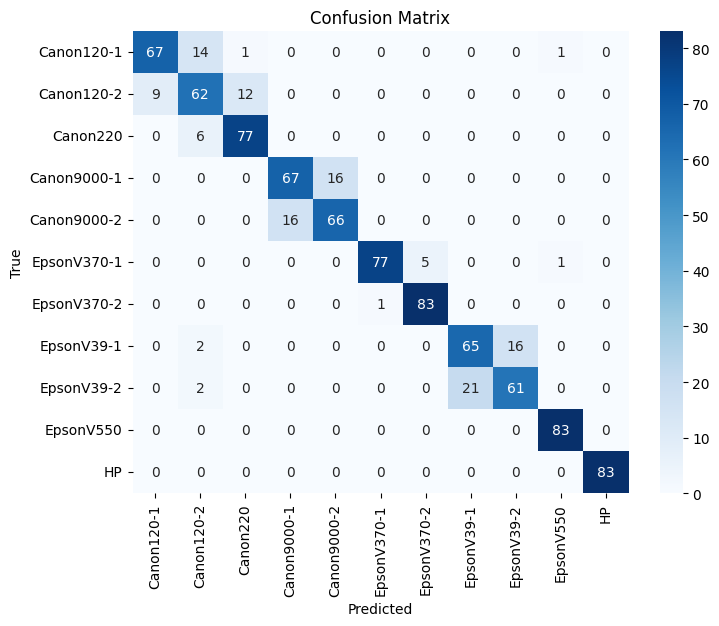

In [ ]:
# ==============================
# Hybrid CNN (Residual Image + Handcrafted Features) with GPU
# ==============================

# ---- Imports & Paths ----
import os, pickle, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from skimage.feature import local_binary_pattern as sk_lbp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

RES_PATH  = "/content/drive/MyDrive/AI_TRACEFINDER_DS/official_wiki_residuals.pkl"
FP_PATH   = "/content/drive/MyDrive/AI_TRACEFINDER_DS/scanner_fingerprints.pkl"
ORDER_NPY = "/content/drive/MyDrive/AI_TRACEFINDER_DS/fp_keys.npy"
ART_DIR   = "/content/drive/MyDrive/AI_TRACEFINDER_DS"
os.makedirs(ART_DIR, exist_ok=True)

# ---- Reproducibility ----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---- GPU Setup ----
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device_name = '/GPU:0'
    print("✅ Using GPU:", gpus[0])
else:
    device_name = '/CPU:0'
    print("⚠️ GPU not found, using CPU")

# ---- Load residuals + fingerprints ----
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()

# ---- Utilities ----
def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()

# ---- Build dataset ----
X_img, X_feat, y = [], [], []
for dataset_name in ["Official", "Wikipedia"]:
    for scanner, dpi_dict in residuals_dict[dataset_name].items():
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                X_img.append(np.expand_dims(res, axis=-1))
                v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                v_fft  = fft_radial_energy(res, K=6)
                v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
                X_feat.append(v_corr + v_fft + v_lbp)
                y.append(scanner)

X_img  = np.array(X_img, dtype=np.float32)
X_feat = np.array(X_feat, dtype=np.float32)
y       = np.array(y)

# ---- Encode labels ----
le = LabelEncoder()
y_int = le.fit_transform(y)
num_classes = len(le.classes_)
y_cat = to_categorical(y_int, num_classes)

X_img_tr, X_img_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_img, X_feat, y_cat, test_size=0.2, random_state=SEED, stratify=y_int
)

scaler = StandardScaler()
X_feat_tr = scaler.fit_transform(X_feat_tr)
X_feat_te = scaler.transform(X_feat_te)

with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print("Hybrid train:", X_img_tr.shape, X_feat_tr.shape, y_tr.shape)
print("Hybrid test :", X_img_te.shape, X_feat_te.shape, y_te.shape)

# -------------------------------
# Build, Train & Evaluate with GPU
# -------------------------------
with tf.device(device_name):
    # ---- Model ----
    img_in  = keras.Input(shape=(256,256,1), name="residual")
    feat_in = keras.Input(shape=(27,),      name="handcrafted")
    hp_kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]], dtype=np.float32).reshape((3,3,1,1))
    hp = layers.Conv2D(1, (3,3), padding="same", use_bias=False, trainable=False, name="hp_filter")(img_in)

    # CNN branch
    x = layers.Conv2D(32,(3,3),padding="same")(hp)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.30)(x)

    x = layers.Conv2D(256,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Feature branch
    f = layers.Dense(64)(feat_in)
    f = layers.BatchNormalization()(f); f = layers.ReLU()(f)
    f = layers.Dropout(0.20)(f)

    # Fusion
    z = layers.Concatenate()([x,f])
    z = layers.Dense(256, activation="relu")(z)
    z = layers.Dropout(0.40)(z)
    out = layers.Dense(num_classes, activation="softmax")(z)

    model = keras.Model(inputs=[img_in, feat_in], outputs=out, name="scanner_hybrid")
    model.get_layer("hp_filter").set_weights([hp_kernel])

    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    # ---- tf.data pipelines ----
    BATCH = 32
    train_ds = tf.data.Dataset.from_tensor_slices(((X_img_tr, X_feat_tr), y_tr))\
        .shuffle(len(y_tr), reshuffle_each_iteration=True)\
        .batch(BATCH).prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices(((X_img_te, X_feat_te), y_te))\
        .batch(BATCH).prefetch(tf.data.AUTOTUNE)

    # ---- Callbacks ----
    ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")
    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor="val_accuracy"),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy"),
    ]

    # ---- Train ----
    EPOCHS = 50
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks, verbose=1)

    # ---- Save model & history ----
    model.save(os.path.join(ART_DIR, "scanner_hybrid_final.keras"))
    with open(os.path.join(ART_DIR, "hybrid_training_history.pkl"), "wb") as f:
        pickle.dump(history.history, f)
    print("✅ Training complete")

    # ---- Evaluate ----
    y_pred_prob = model.predict(val_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_te, axis=1)


    test_acc = accuracy_score(y_true, y_pred)
    print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

    print("\n✅ Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)


GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


                                                                   Testing

In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
import pywt
import cv2

# -----------------------
# Paths
# -----------------------
ART_DIR = "/content/drive/MyDrive/AI_TRACEFINDER_DS"
FP_PATH = os.path.join(ART_DIR, "scanner_fingerprints.pkl")
ORDER_NPY = os.path.join(ART_DIR, "fp_keys.npy")
ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")  # <-- checkpoint path

# -----------------------
# Reload for inference
# -----------------------
hyb_model = tf.keras.models.load_model(ckpt_path, compile=False)

with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "rb") as f:
    le_inf = pickle.load(f)

with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "rb") as f:
    scaler_inf = pickle.load(f)

with open(FP_PATH, "rb") as f:
    scanner_fps_inf = pickle.load(f)

fp_keys_inf = np.load(ORDER_NPY, allow_pickle=True).tolist()
IMG_SIZE = (256, 256)

# -----------------------
# Utility functions
# -----------------------
def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    from skimage.feature import local_binary_pattern
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()

# -----------------------
# Preprocess + Features
# -----------------------
def preprocess_residual_pywt(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def make_feats_from_res(res):
    v_corr = [corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]
    v_fft  = fft_radial_energy(res, K=6)
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
    v = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    v = scaler_inf.transform(v)
    return v

# -----------------------
# Prediction function
# -----------------------
def predict_scanner_hybrid(image_path):
    res   = preprocess_residual_pywt(image_path)
    x_img = np.expand_dims(res, axis=(0,-1))  # (1,256,256,1)
    x_ft  = make_feats_from_res(res)          # (1,27)
    prob  = hyb_model.predict([x_img, x_ft], verbose=0)
    idx   = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[0, idx]*100.0)
    return label, conf

# -----------------------
# Multiple image prediction
# -----------------------
test_paths = [
   "/content/drive/MyDrive/AI_TRACEFINDER_DS/Official/Canon220/150/s3_25.tif",
   "/content/drive/MyDrive/AI_TRACEFINDER_DS/Official/HP/150/s11_22.tif",
   "/content/drive/MyDrive/AI_TRACEFINDER_DS/Wikipedia/Canon120-1/300/s1_5.tif",
]

for p in test_paths:
    label, conf = predict_scanner_hybrid(p)
    print(f"{p} -> {label} | Confidence: {conf:.2f}%")


/content/drive/MyDrive/AI_TRACEFINDER_DS/Official/Canon220/150/s3_25.tif -> Canon220 | Confidence: 66.52%
/content/drive/MyDrive/AI_TRACEFINDER_DS/Official/HP/150/s11_22.tif -> HP | Confidence: 100.00%
/content/drive/MyDrive/AI_TRACEFINDER_DS/Wikipedia/Canon120-1/300/s1_5.tif -> Canon120-2 | Confidence: 63.86%


In [ ]:
import os
import glob
import pickle
import numpy as np
import tensorflow as tf
import pywt
import cv2

# -----------------------
# Paths
# -----------------------
ART_DIR = "/content/drive/MyDrive/AI_TRACEFINDER_DS"
FP_PATH = os.path.join(ART_DIR, "scanner_fingerprints.pkl")
ORDER_NPY = os.path.join(ART_DIR, "fp_keys.npy")
ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")  # checkpoint path

# -----------------------
# Reload for inference
# -----------------------
hyb_model = tf.keras.models.load_model(ckpt_path, compile=False)

with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "rb") as f:
    le_inf = pickle.load(f)

with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "rb") as f:
    scaler_inf = pickle.load(f)

with open(FP_PATH, "rb") as f:
    scanner_fps_inf = pickle.load(f)

fp_keys_inf = np.load(ORDER_NPY, allow_pickle=True).tolist()
IMG_SIZE = (256, 256)

# -----------------------
# Utility functions
# -----------------------
def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    from skimage.feature import local_binary_pattern
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()

# -----------------------
# Preprocess + Features
# -----------------------
def preprocess_residual_pywt(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def make_feats_from_res(res):
    v_corr = [corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]
    v_fft  = fft_radial_energy(res, K=6)
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
    v = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    v = scaler_inf.transform(v)
    return v

# -----------------------
# Prediction function
# -----------------------
def predict_scanner_hybrid(image_path):
    res   = preprocess_residual_pywt(image_path)
    x_img = np.expand_dims(res, axis=(0,-1))  # (1,256,256,1)
    x_ft  = make_feats_from_res(res)          # (1,27)
    prob  = hyb_model.predict([x_img, x_ft], verbose=0)
    idx   = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[0, idx]*100.0)
    return label, conf

# -----------------------
# Predict all images in a folder
# -----------------------
def predict_folder(folder_path, exts=("*.tif","*.png","*.jpg","*.jpeg")):
    # Gather all files recursively
    image_files = []
    for ext in exts:
        image_files.extend(glob.glob(os.path.join(folder_path, "**", ext), recursive=True))
    print(f"Found {len(image_files)} images in {folder_path}")

    # Predict each
    results = []
    for img_path in image_files:
        try:
            label, conf = predict_scanner_hybrid(img_path)
            results.append((img_path, label, conf))
            print(f"{img_path} -> {label} | Confidence: {conf:.2f}%")
        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")
    return results

# -----------------------
# Example usage
# -----------------------
folder_to_test = "/content/drive/MyDrive/AI_TRACEFINDER_DS/Test"
all_results = predict_folder(folder_to_test)


Found 6 images in /content/drive/MyDrive/AI_TRACEFINDER_DS/Test
/content/drive/MyDrive/AI_TRACEFINDER_DS/Test/s10_106.tif -> EpsonV550 | Confidence: 98.94%
/content/drive/MyDrive/AI_TRACEFINDER_DS/Test/s5_105.tif -> Canon9000-2 | Confidence: 97.52%
/content/drive/MyDrive/AI_TRACEFINDER_DS/Test/s11_107.tif -> HP | Confidence: 100.00%
/content/drive/MyDrive/AI_TRACEFINDER_DS/Test/s11_104.tif -> HP | Confidence: 100.00%
/content/drive/MyDrive/AI_TRACEFINDER_DS/Test/s8_108.tif -> EpsonV39-1 | Confidence: 76.29%
/content/drive/MyDrive/AI_TRACEFINDER_DS/Test/s8_102.tif -> EpsonV39-1 | Confidence: 68.96%


                                                              Tampered detection

In [2]:
import os
ROOT = "/content/drive/MyDrive/AI_TRACEFINDER_DS"

# Originals PDFs to convert → TIFF
ORIG_PDF_OFF = f"{ROOT}/Originals/official"
ORIG_PDF_WIK = f"{ROOT}/Originals/wikipedia"
CONV_OUT     = f"{ROOT}/Originals_tif"           # output for converted TIFFs
os.makedirs(CONV_OUT, exist_ok=True)

# Tampered images TIFFs
TAMP_ROOT     = f"{ROOT}/TamperedImages"
TAMP_ORIG_TIF = f"{TAMP_ROOT}/Original"                          # clean (0)
TAMP_COPY_TIF = f"{TAMP_ROOT}/Tampered/Copy-move"                # tampered (1)
TAMP_RETO_TIF = f"{TAMP_ROOT}/Tampered/Retouching"               # tampered (1)
TAMP_SPLI_TIF = f"{TAMP_ROOT}/Tampered/Splicing"                 # tampered (1)

# Artifacts / manifests
ART_DIR      = f"{ROOT}/artifacts_tamper"
MANIFEST_CSV = f"{ROOT}/manifests/tamper_manifest.csv"
os.makedirs(ART_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MANIFEST_CSV), exist_ok=True)


In [4]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 78.0 MB/s eta 0:00:00


In [ ]:
import os, glob
from pathlib import Path
from PIL import Image  # Pillow (PIL) [web:28]

import pymupdf as fitz  # modern namespace; keeps existing fitz.* calls working [web:14][web:30]

def pdf_to_tiffs(pdf_path, out_dir, dpi=300):
    os.makedirs(out_dir, exist_ok=True)
    doc = fitz.open(pdf_path)
    for i, page in enumerate(doc):
        pix = page.get_pixmap(dpi=dpi)  # documented DPI rendering
        mode = "RGB" if pix.alpha == 0 else "RGBA"
        img = Image.frombytes(mode, [pix.width, pix.height], pix.samples)
        if img.mode != "RGB":
            img = img.convert("RGB")
        stem = Path(pdf_path).stem
        outp = f"{out_dir}/{stem}_p{i+1}.tif"
        img.save(outp, format="TIFF", dpi=(dpi, dpi), compression="tiff_deflate")
    doc.close()

def batch_convert_originals():
    tasks = []
    for sub in ["official", "wikipedia"]:
        src_root = f"{ROOT}/Originals/{sub}"
        dst_root = f"{CONV_OUT}/{sub}"
        os.makedirs(dst_root, exist_ok=True)
        for pdf in glob.glob(f"{src_root}/**/*.pdf", recursive=True):
            parent = Path(pdf).parent.name
            out_dir = f"{dst_root}/{parent}"
            tasks.append((pdf, out_dir))
    for pdf, outd in tqdm(tasks, desc="PDF→TIFF 300dpi"):
        try:
            pdf_to_tiffs(pdf, outd, dpi=300)
        except Exception as e:
            print("Failed:", pdf, "->", e)

batch_convert_originals()


PDF→TIFF 300dpi: 100%|██████████| 208/208 [03:32<00:00,  1.02s/it]


In [7]:
ROOT = "/content/drive/MyDrive/AI_TRACEFINDER_DS"
ORIG_TIF_OFF = f"{ROOT}/Originals_tif/official"
ORIG_TIF_WIK = f"{ROOT}/Originals_tif/wikipedia"
TAMP_ROOT    = f"{ROOT}/TamperedImages"
TAMP_ORIG_TF = f"{TAMP_ROOT}/Original"
TAMP_CM_TF   = f"{TAMP_ROOT}/Tampered/Copy-move"
TAMP_RT_TF   = f"{TAMP_ROOT}/Tampered/Retouching"
TAMP_SP_TF   = f"{TAMP_ROOT}/Tampered/Splicing"


In [8]:
import os, glob, csv, re
from pathlib import Path

MANIFEST_CSV = f"{ROOT}/manifests/tamper_manifest_grouped.csv"
os.makedirs(os.path.dirname(MANIFEST_CSV), exist_ok=True)

def list_tifs(root):
    return sorted([p for p in glob.glob(f"{root}/**/*", recursive=True)
                   if p.lower().endswith((".tif",".tiff"))])

def infer_page_id(p):
    m = re.search(r"(s\d+_\d+)", os.path.basename(p))
    if m: return m.group(1)
    stem = Path(p).stem
    stem = re.sub(r"_p\d+$","", stem)
    return stem

rows = [["path","label","domain","tamper_type","page_id"]]
for p in list_tifs(ORIG_TIF_OFF): rows.append([p, 0, "orig_pdf_tif", "clean",     infer_page_id(p)])
for p in list_tifs(ORIG_TIF_WIK): rows.append([p, 0, "orig_pdf_tif", "clean",     infer_page_id(p)])
for p in list_tifs(TAMP_ORIG_TF): rows.append([p, 0, "tamper_dir",   "clean",     infer_page_id(p)])
for p in list_tifs(TAMP_CM_TF):   rows.append([p, 1, "tamper_dir",   "copy-move", infer_page_id(p)])
for p in list_tifs(TAMP_RT_TF):   rows.append([p, 1, "tamper_dir",   "retouch",   infer_page_id(p)])
for p in list_tifs(TAMP_SP_TF):   rows.append([p, 1, "tamper_dir",   "splice",    infer_page_id(p)])

with open(MANIFEST_CSV, "w", newline="") as fh:
    csv.writer(fh).writerows(rows)
print("Wrote manifest:", MANIFEST_CSV, "rows:", len(rows)-1)


Wrote manifest: /content/drive/MyDrive/AI_TRACEFINDER_DS/manifests/tamper_manifest_grouped.csv rows: 344


In [9]:
import numpy as np, cv2, pywt, math
from skimage.feature import local_binary_pattern as sk_lbp

IMG_SIZE = (256,256)
PATCH = 128
STRIDE = 64
MAX_PATCHES = 16

def load_to_residual(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise ValueError(f"Cannot read {path}")
    if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    cA,(cH,cV,cD) = pywt.dwt2(img, "haar")
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA,(cH,cV,cD)), "haar")
    return (img - den).astype(np.float32)

def extract_patches(res, patch=PATCH, stride=STRIDE, limit=MAX_PATCHES, seed=42):
    H,W = res.shape
    ys = list(range(0, H-patch+1, stride))
    xs = list(range(0, W-patch+1, stride))
    coords = [(y,x) for y in ys for x in xs]
    rng = np.random.RandomState(seed)
    rng.shuffle(coords)
    coords = coords[:min(limit, len(coords))]
    return [res[y:y+patch, x:x+patch] for y,x in coords]


In [10]:
def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32)

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    bins = np.linspace(0, r.max()+1e-6, K+1)
    feats=[]
    for i in range(K):
        m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
    return np.asarray(feats, dtype=np.float32)

def residual_stats(img):
    return np.asarray([float(img.mean()), float(img.std()), float(np.mean(np.abs(img)))], dtype=np.float32)

def fft_resample_feats(img):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    rmax = r.max()+1e-6
    b1 = (r>=0.25*rmax) & (r<0.35*rmax)
    b2 = (r>=0.35*rmax) & (r<0.50*rmax)
    e1 = float(mag[b1].mean() if b1.any() else 0.0)
    e2 = float(mag[b2].mean() if b2.any() else 0.0)
    ratio = float(e2/(e1+1e-8))
    return np.asarray([e1, e2, ratio], dtype=np.float32)

def make_feat_vector(img_patch):
    lbp = lbp_hist_safe(img_patch,8,1.0)      # 10
    fft6 = fft_radial_energy(img_patch,6)     # 6
    res3 = residual_stats(img_patch)          # 3
    rsp3 = fft_resample_feats(img_patch)      # 3
    return np.concatenate([lbp, fft6, res3, rsp3], axis=0)


In [11]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import csv

with open(MANIFEST_CSV, "r") as fh:
    rr = list(csv.DictReader(fh))

paths  = np.array([r["path"] for r in rr], dtype=object)
labels = np.array([int(r["label"]) for r in rr], dtype=np.int64)
groups = np.array([r["page_id"] for r in rr], dtype=object)
domain = np.array([r["domain"] for r in rr], dtype=object)
ttype  = np.array([r["tamper_type"] for r in rr], dtype=object)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
tr_idx, va_idx = next(sgkf.split(paths, labels, groups))

def augment_patch(p):
    a = p.copy()
    a = a + 0.003*np.random.randn(*a.shape)
    if np.random.rand()<0.5:
        a = cv2.GaussianBlur(a, (3,3), 0)
    a = np.clip(a, 0.0, 1.0).astype(np.float32)
    return a

def build_patchset(idxs, balance_clean_domains=True, seed=42, aug_clean_tdir=True):
    Xp, yp, dp, tp, gp, ip = [], [], [], [], [], []
    rng = np.random.RandomState(seed)
    idxs_clean = [i for i in idxs if labels[i]==0]
    idxs_clean_orig = [i for i in idxs_clean if domain[i]=="orig_pdf_tif"]
    idxs_clean_tdir = [i for i in idxs_clean if domain[i]=="tamper_dir"]
    if balance_clean_domains and len(idxs_clean_orig)>0 and len(idxs_clean_tdir)>0:
        cap = min(len(idxs_clean_orig), len(idxs_clean_tdir))
        rng.shuffle(idxs_clean_orig); rng.shuffle(idxs_clean_tdir)
        idxs_use = idxs_clean_orig[:cap] + idxs_clean_tdir[:cap] + [i for i in idxs if labels[i]==1]
    else:
        idxs_use = list(idxs)
    for i in tqdm(idxs_use, desc="patchify+debias"):
        res = load_to_residual(paths[i])
        patches = extract_patches(res, limit=MAX_PATCHES, seed=(seed+i)%10000)
        for pch in patches:
            if aug_clean_tdir and labels[i]==0 and domain[i]=="tamper_dir":
                pch = augment_patch(pch)
            Xp.append(make_feat_vector(pch))
            yp.append(labels[i]); dp.append(domain[i]); tp.append(ttype[i]); gp.append(groups[i]); ip.append(paths[i])
    return np.asarray(Xp, np.float32), np.asarray(yp, np.int64), np.array(dp, dtype=object), np.array(tp, dtype=object), np.array(gp, dtype=object), np.array(ip, dtype=object)

Xtr, ytr, dtr, ttr, gtr, itr = build_patchset(tr_idx, balance_clean_domains=True, aug_clean_tdir=True)
Xva, yva, dva, tva, gva, iva = build_patchset(va_idx, balance_clean_domains=False, aug_clean_tdir=False)

scaler = StandardScaler().fit(Xtr)
Xs_tr = scaler.transform(Xtr)
Xs_va = scaler.transform(Xva)


patchify+debias: 100%|██████████| 70/70 [02:14<00:00,  1.92s/it]


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score

# --- Scale features ---
scaler = StandardScaler().fit(Xtr)   # fit only on train
Xs_tr = scaler.transform(Xtr)
Xs_va = scaler.transform(Xva)

# --- Train classifier ---
base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False,
           class_weight="balanced", random_state=42)
clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xs_tr, ytr)

# --- Training accuracy ---
train_acc = clf.score(Xs_tr, ytr)
print("Training accuracy:", train_acc)

# --- Validation AUC ---
probs_va = clf.predict_proba(Xs_va)[:, 1]
auc_patch = roc_auc_score(yva, probs_va)
print("Validation Patch-level AUC:", auc_patch)

# --- Threshold selection ---
def best_thr(y, p):
    fpr, tpr, thr = roc_curve(y, p)
    j = tpr - fpr
    return float(thr[int(np.argmax(j))])

thr_global = best_thr(yva, probs_va)

thr_by_domain = {}
for dom in ["orig_pdf_tif", "tamper_dir"]:
    m = (dva == dom)
    if m.any() and len(np.unique(yva[m])) == 2:
        thr_by_domain[dom] = best_thr(yva[m], probs_va[m])

thr_by_type = {}
for t in ["copy-move", "retouch", "splice"]:
    m = (tva == t) | (tva == "clean")
    if m.any() and len(np.unique(yva[m])) == 2:
        thr_by_type[t] = best_thr(yva[m], probs_va[m])

print("Global thr:", thr_global)
print("Per-domain:", thr_by_domain)
print("Per-type:", thr_by_type)


Training accuracy: 0.9958847736625515
Validation Patch-level AUC: 0.9268977432242739
Global thr: 0.8021084715652925
Per-domain: {'tamper_dir': 0.9998674879604224}
Per-type: {'copy-move': 0.8375097641011239, 'retouch': 0.8375097641011239, 'splice': 0.8021084715652925}


In [13]:
import json, pickle, os
ART_TP = f"{ROOT}/artifacts_tamper_patch"
os.makedirs(ART_TP, exist_ok=True)
with open(f"{ART_TP}/patch_scaler.pkl","wb") as f: pickle.dump(scaler,f)
with open(f"{ART_TP}/patch_svm_sig_calibrated.pkl","wb") as f: pickle.dump(clf,f)
with open(f"{ART_TP}/thresholds_patch.json","w") as f: json.dump({"global": thr_global, "by_domain": thr_by_domain, "by_type": thr_by_type}, f)
print("Saved:", ART_TP)


Saved: /content/drive/MyDrive/AI_TRACEFINDER_DS/artifacts_tamper_patch


In [14]:
import glob

PAIR_CSV = f"{ROOT}/manifests/tamper_pairs.csv"
os.makedirs(os.path.dirname(PAIR_CSV), exist_ok=True)

orig_clean = glob.glob(f"{TAMP_ROOT}/Original/*.tif")
tampered_a = glob.glob(f"{TAMP_ROOT}/Tampered/Splicing/*.tif")
tampered_b = glob.glob(f"{TAMP_ROOT}/Tampered/Copy-move/*.tif")
tampered_c = glob.glob(f"{TAMP_ROOT}/Tampered/Retouching/*.tif")

def pid(p):
    m=re.search(r"(s\d+_\d+)", os.path.basename(p))
    return m.group(1) if m else None

orig_map = {pid(p): p for p in orig_clean}
pairs = []
for ttype, lst in [("splice", tampered_a), ("copy-move", tampered_b), ("retouch", tampered_c)]:
    for p in lst:
        k = pid(p)
        if k in orig_map:
            pairs.append([orig_map[k], p, ttype, k])

with open(PAIR_CSV, "w", newline="") as fh:
    csv.writer(fh).writerows([["clean_path","tampered_path","tamper_type","page_id"]] + pairs)
print("Wrote pairs:", len(pairs), "->", PAIR_CSV)


Wrote pairs: 102 -> /content/drive/MyDrive/AI_TRACEFINDER_DS/manifests/tamper_pairs.csv


In [15]:
import csv, numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score

def paired_patch_features(p_clean, p_tamp, limit=MAX_PATCHES, seed=42):
    r1 = load_to_residual(p_clean); r2 = load_to_residual(p_tamp)
    patches1 = extract_patches(r1, limit=limit, seed=seed)
    patches2 = extract_patches(r2, limit=limit, seed=seed)
    n = min(len(patches1), len(patches2))
    Xd=[]
    for i in range(n):
        f1 = make_feat_vector(patches1[i])
        f2 = make_feat_vector(patches2[i])
        Xd.append(f2 - f1)
    return np.asarray(Xd, np.float32)

rows_p = list(csv.DictReader(open(PAIR_CSV)))
X_pair, y_pair, types = [], [], []
for r in rows_p:
    Xd = paired_patch_features(r["clean_path"], r["tampered_path"], limit=MAX_PATCHES, seed=123)
    X_pair.append(np.mean(Xd, axis=0)); y_pair.append(1); types.append(r["tamper_type"])
for r in rows_p:
    Xd = paired_patch_features(r["clean_path"], r["clean_path"], limit=MAX_PATCHES, seed=456)
    X_pair.append(np.mean(Xd, axis=0)); y_pair.append(0); types.append("clean")

X_pair = np.asarray(X_pair, np.float32)
y_pair = np.asarray(y_pair, np.int64)
types  = np.asarray(types, dtype=object)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tr_i, va_i = next(skf.split(X_pair, y_pair))
sc_pair = StandardScaler().fit(X_pair[tr_i])
Xp_tr = sc_pair.transform(X_pair[tr_i])
Xp_va = sc_pair.transform(X_pair[va_i])

base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False, class_weight="balanced", random_state=42)
pair_clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xp_tr, y_pair[tr_i])

probs_va_pair = pair_clf.predict_proba(Xp_va)[:,1]
print("Paired AUC (mean-delta):", roc_auc_score(y_pair[va_i], probs_va_pair))

# Top-k image scores per pair on validation
import math
def topk_mean(arr, frac=0.30):
    n = len(arr); k = max(1, int(math.ceil(frac*n)))
    return float(np.mean(np.sort(arr)[-k:]))

def paired_patch_probs(clean_path, tampered_path, limit=MAX_PATCHES, seed=321):
    Xd = paired_patch_features(clean_path, tampered_path, limit=limit, seed=seed)
    Xd_s = sc_pair.transform(Xd)
    return pair_clf.predict_proba(Xd_s)[:,1]

half = len(rows_p)
va_scores, va_labels, va_types = [], [], []
for idx in va_i:
    if idx < half:
        r = rows_p[idx]
        pc, pt, typ = r["clean_path"], r["tampered_path"], r["tamper_type"]
        p_img = topk_mean(paired_patch_probs(pc, pt, limit=MAX_PATCHES, seed=999), frac=0.30)
        va_scores.append(p_img); va_labels.append(1); va_types.append(typ)
    else:
        ridx = idx - half
        r = rows_p[ridx]
        pc = r["clean_path"]
        p_img = topk_mean(paired_patch_probs(pc, pc, limit=MAX_PATCHES, seed=111), frac=0.30)
        va_scores.append(p_img); va_labels.append(0); va_types.append("clean")

va_scores = np.array(va_scores, np.float32)
va_labels = np.array(va_labels, np.int64)
va_types  = np.array(va_types, dtype=object)

# Compute per-type thresholds using Youden’s J (type vs clean)
fpr,tpr,thr = roc_curve(va_labels, va_scores)
thr_pair_global_topk = float(thr[int(np.argmax(tpr - fpr))])

thr_pair_by_type = {}
for typ in ["copy-move","retouch","splice"]:
    m = (va_types==typ) | (va_types=="clean")
    if m.any() and len(np.unique(va_labels[m]))==2:
        f,t,th = roc_curve(va_labels[m], va_scores[m])
        thr_pair_by_type[typ] = float(th[int(np.argmax(t - f))])

import pickle, json, os
ART_PAIR = f"{ROOT}/artifacts_tamper_pair"
os.makedirs(ART_PAIR, exist_ok=True)
with open(f"{ART_PAIR}/pair_scaler.pkl","wb") as f: pickle.dump(sc_pair,f)
with open(f"{ART_PAIR}/pair_svm_sig.pkl","wb") as f: pickle.dump(pair_clf,f)
with open(f"{ART_PAIR}/pair_thresholds_topk.json","w") as f:
    json.dump({"global": thr_pair_global_topk, "by_type": thr_pair_by_type}, f)
print("Saved paired artifacts:", ART_PAIR)


Paired AUC (mean-delta): 0.8095238095238095
Saved paired artifacts: /content/drive/MyDrive/AI_TRACEFINDER_DS/artifacts_tamper_pair


In [24]:
import os, re, glob, math, json, pickle
import numpy as np, cv2, pywt, tensorflow as tf
from skimage.feature import local_binary_pattern as sk_lbp

# --------------------
# Base paths and constants
# --------------------
ROOT = "/content/drive/MyDrive/AI_TRACEFINDER_DS"
TAMP_ROOT = f"{ROOT}/TamperedImages"
IMG_SIZE = (256,256)
PATCH = 128
STRIDE = 64
MAX_PATCHES = 16

# --------------------
# Residual frontend and features
# --------------------
def load_to_residual(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    cA,(cH,cV,cD) = pywt.dwt2(img, "haar")
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA,(cH,cV,cD)), "haar")
    return (img - den).astype(np.float32)

def extract_patches(res, patch=PATCH, stride=STRIDE, limit=MAX_PATCHES, seed=42):
    H,W = res.shape
    ys = list(range(0, H-patch+1, stride))
    xs = list(range(0, W-patch+1, stride))
    coords = [(y,x) for y in ys for x in xs]
    rng = np.random.RandomState(seed)
    rng.shuffle(coords)
    coords = coords[:min(limit, len(coords))]
    return [res[y:y+patch, x:x+patch] for y,x in coords]

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32)

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    bins = np.linspace(0, r.max()+1e-6, K+1)
    feats=[]
    for i in range(K):
        m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
    return np.asarray(feats, dtype=np.float32)

def residual_stats(img):
    return np.asarray([float(img.mean()), float(img.std()), float(np.mean(np.abs(img)))], dtype=np.float32)

def fft_resample_feats(img):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    rmax = r.max()+1e-6
    b1 = (r>=0.25*rmax) & (r<0.35*rmax)
    b2 = (r>=0.35*rmax) & (r<0.50*rmax)
    e1 = float(mag[b1].mean() if b1.any() else 0.0)
    e2 = float(mag[b2].mean() if b2.any() else 0.0)
    ratio = float(e2/(e1+1e-8))
    return np.asarray([e1, e2, ratio], dtype=np.float32)

def make_feat_vector(img_patch):
    lbp = lbp_hist_safe(img_patch,8,1.0)
    fft6 = fft_radial_energy(img_patch,6)
    res3 = residual_stats(img_patch)
    rsp3 = fft_resample_feats(img_patch)
    return np.concatenate([lbp, fft6, res3, rsp3], axis=0)

# --------------------
# Objective 1: Scanner-ID artifacts (11 scanners only)
# --------------------
ART_SCN = ROOT
MODEL = f"{ART_SCN}/scanner_hybrid.keras"
LE_PATH = f"{ART_SCN}/hybrid_label_encoder.pkl"
SCALER_PATH = f"{ART_SCN}/hybrid_feat_scaler.pkl"
FPS = f"{ART_SCN}/scanner_fingerprints.pkl"
FP_KEYS = f"{ART_SCN}/fp_keys.npy"

with open(FPS,"rb") as f: fps_all = pickle.load(f)
fp_keys_all = np.load(FP_KEYS, allow_pickle=True).tolist()

# The valid_scanners list seems to be for a different purpose than the original model.
# The original model was trained on all scanners present in the dataset.
# We should use the scanner keys from the loaded fingerprint file for consistency.
valid_scanners = fp_keys_all # Use all scanners the model was trained on

fps = {k: fps_all[k] for k in fp_keys_all if k in valid_scanners}
fp_keys = [k for k in fp_keys_all if k in valid_scanners]

hyb_model = tf.keras.models.load_model(MODEL)
with open(LE_PATH,"rb") as f: le_sc = pickle.load(f)
# Filter label encoder classes based on valid_scanners if necessary,
# but it's better to use the original classes the model was trained on.
# le_sc.classes_ = np.array([c for c in le_sc.classes_ if c in valid_scanners])


with open(SCALER_PATH,"rb") as f: sc_sc = pickle.load(f)
n_in = int(getattr(sc_sc, "n_features_in_", 0))
# The scaler expects 27 features, which is the size of the feature vector calculated below.
# The error was due to an incorrect check for 30-D.
if n_in != 27:
    raise RuntimeError(f"Loaded scaler expects {n_in} features; it must be 27-D based on model training.")


_dummy = np.zeros((256,256), np.float32)
_feat = np.asarray([0]*27, np.float32).reshape(1, -1) # Change dummy feature size to 27
_h = hyb_model.input[1].shape[-1] if isinstance(hyb_model.input, (list, tuple)) else None

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b)/d) if d!=0 else 0.0

def fft_radial_energy_img(img, K=6):
    return fft_radial_energy(img, K=K)

def make_scanner_feats(res):
    v_corr = [corr2d(res, fps[k]) for k in fp_keys]
    v_fft  = fft_radial_energy_img(res, K=6)
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
    feat = v_corr + list(v_fft) + list(v_lbp)
    # Ensure the feature vector is exactly 27-D (11 corr + 6 fft + 10 lbp)
    feat = np.asarray(feat, dtype=np.float32)
    if feat.size != 27:
         raise RuntimeError(f"Generated scanner feature vector size is {feat.size}, expected 27.")
    return sc_sc.transform(feat.reshape(1,-1))


# --------------------
# Objective 2: Paired artifacts and high-recall inference
# --------------------
ART_PAIR = f"{ROOT}/artifacts_tamper_pair"
with open(f"{ART_PAIR}/pair_scaler.pkl","rb") as f: sc_pair = pickle.load(f)
with open(f"{ART_PAIR}/pair_svm_sig.pkl","rb") as f: pair_clf = pickle.load(f)
with open(f"{ART_PAIR}/pair_thresholds_topk.json","r") as f: THR_PAIR = json.load(f)


orig_map = {re.search(r"(s\d+_\d+)", os.path.basename(p)).group(1): p
            for p in glob.glob(f"{TAMP_ROOT}/Original/*.tif")}


def pid_from_path(p):
    m = re.search(r"(s\d+_\d+)", os.path.basename(p))
    return m.group(1) if m else None


def paired_patch_features(p_clean, p_tamp, limit=MAX_PATCHES, seed=42):
    r1 = load_to_residual(p_clean); r2 = load_to_residual(p_tamp)
    patches1 = extract_patches(r1, limit=limit, seed=seed)
    patches2 = extract_patches(r2, limit=limit, seed=seed)
    n = min(len(patches1), len(patches2))
    Xd=[]
    H,W = r1.shape
    ys = list(range(0, H-PATCH+1, STRIDE))
    xs = list(range(0, W-PATCH+1, STRIDE))
    coords = [(y,x) for y in ys for x in xs][:n]
    for i in range(n):
        f1 = make_feat_vector(patches1[i])
        f2 = make_feat_vector(patches2[i])
        Xd.append(f2 - f1)
    return np.asarray(Xd, np.float32), coords


def adjacency_hits_topk(idxs, coords):
    S = set(idxs)
    pos = {i: coords[i] for i in range(len(coords))}
    adj = 0
    for i in idxs:
        y,x = pos[i]
        neigh = {(y-STRIDE,x),(y+STRIDE,x),(y,x-STRIDE),(y,x+STRIDE)}
        if any((pos[j] in neigh) for j in S if j!=i):
            adj += 1
    return adj


def edge_change_score(p1, p2):
    s1 = cv2.Sobel(p1, cv2.CV_32F, 1, 1, ksize=3)
    s2 = cv2.Sobel(p2, cv2.CV_32F, 1, 1, ksize=3)
    return float(np.mean(np.abs(s2) - np.abs(s1)))


def paired_infer_type_aware(clean_path, suspect_path, tamper_type_hint=None, frac=0.30):
    # Paired probs and coords
    r1 = load_to_residual(clean_path)
    r2 = load_to_residual(suspect_path)
    patches1 = extract_patches(r1, limit=MAX_PATCHES, seed=777)
    patches2 = extract_patches(r2, limit=MAX_PATCHES, seed=777)


    Xd, coords = paired_patch_features(clean_path, suspect_path, limit=MAX_PATCHES, seed=777)
    Xd_s = sc_pair.transform(Xd)
    p_patch = pair_clf.predict_proba(Xd_s)[:,1]


    typ = (tamper_type_hint or "unknown").lower()
    thr_base = THR_PAIR["by_type"].get(typ, THR_PAIR["global"])
    thr_eff = max(thr_base - 0.02, 0.0)


    # top-k set and score
    frac_use = 0.20 if typ == "retouch" else 0.30
    n = len(p_patch); k = max(1, int(math.ceil(frac_use*n)))
    top_idx = np.argsort(p_patch)[-k:]
    p_img = float(np.mean(p_patch[top_idx]))


    def hits_topk(gate): return int(np.sum(p_patch[top_idx] >= gate))


    if typ == "copy-move":
        local_gate = 0.78
        hits = hits_topk(local_gate)
        ok = (p_img >= (thr_eff - 0.05)) or ((p_img >= thr_eff) and (hits >= 2))
        thr_used = thr_eff - 0.05


    elif typ == "retouch":
        # Final high-recall RT: accept p >= 0.60 outright, or require mild local evidence near thr
        local_gate = 0.75
        hits = hits_topk(local_gate)
        ok = (p_img >= 0.60) or ((p_img >= max(thr_eff, 0.65)) and (hits >= 2))
        thr_used = 0.60


    else:
        local_gate = 0.80
        hits = hits_topk(local_gate)
        ok = (p_img >= thr_base) and (hits >= 2)
        thr_used = thr_base


    tampered = int(ok)
    conf = float((p_img if tampered else 1.0 - p_img)*100.0)
    return {"prob_tampered": p_img,
            "tamper_label": "Tampered" if tampered else "Clean",
            "threshold": thr_used, "confidence": conf, "hits": hits}

# --------------------
# Objective 3: Single-image tamper detection
# --------------------
ART_IMG = f"{ROOT}/artifacts_tamper_image_v1"
with open(f"{ART_IMG}/image_scaler.pkl","rb") as f: sc_img = pickle.load(f)
with open(f"{ART_IMG}/image_svm_sig.pkl","rb") as f: img_clf = pickle.load(f)
with open(f"{ART_IMG}/image_thresholds.json","r") as f: THR_IMG = json.load(f)

def patch_feat_single(p):
    # This needs to match the features used for the image-level classifier
    from skimage.feature import local_binary_pattern as sk_lbp
    def lbp_hist_safe_single(img, P=8, R=1.0):
        rng = float(np.ptp(img))
        g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
        g8 = (g * 255.0).astype(np.uint8)
        codes = sk_lbp(g8, P=P, R=R, method="uniform")
        n_bins = P + 2
        hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
        return hist.astype(np.float32)
    def fft_radial_energy_single(img, K=6):
        f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
        h,w = mag.shape; cy,cx = h//2, w//2
        yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
        bins = np.linspace(0, r.max()+1e-6, K+1)
        feats=[]
        for i in range(K):
            m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
        return np.asarray(feats, dtype=np.float32)
    def contrast_stat_single(img):
        return np.asarray([float(np.std(img)) , float(np.mean(np.abs(img - np.mean(img))))], dtype=np.float32)

    return np.concatenate([lbp_hist_safe_single(p,8,1.0), fft_radial_energy_single(p,6), contrast_stat_single(p)], axis=0)  # 18-D


def infer_tamper_single(path, tamper_type_hint=None, frac=0.30):
    res = load_to_residual(path)
    patches = extract_patches(res, limit=MAX_PATCHES, seed=789)
    feats = np.stack([patch_feat_single(p) for p in patches], 0) if patches else np.zeros((1,18), np.float32)
    X_img_feat = np.mean(feats, axis=0).reshape(1,-1)

    X_img_feat_scaled = sc_img.transform(X_img_feat)
    prob = img_clf.predict_proba(X_img_feat_scaled)[:,1][0]

    # Determine domain for thresholding
    domain = "unknown"
    if "/Originals_tif/official" in path: domain = "orig_pdf_tif"
    elif "/Originals_tif/wikipedia" in path: domain = "orig_pdf_tif"
    elif "/TamperedImages" in path: domain = "tamper_dir"

    thr_base = THR_IMG["by_domain"].get(domain, THR_IMG["global"])
    tampered = int(prob >= thr_base)
    conf = float((prob if tampered else 1.0 - prob)*100.0)

    # Single-image doesn't have "hits" or type-aware thresholds in this simple version
    return {"prob_tampered": prob,
            "tamper_label": "Tampered" if tampered else "Clean",
            "threshold": thr_base, "confidence": conf,
            "domain": domain, "hits": -1} # -1 indicates not applicable for single

# --------------------
# Unified prediction (scanner first, then tamper)
# --------------------
def predict_scanner_and_tamper(path, tamper_type_hint=None, frac=0.30):
    # Scanner-ID first
    res = load_to_residual(path)
    x_img = np.expand_dims(res, axis=(0,-1))
    x_ft  = make_scanner_feats(res)
    ps = hyb_model.predict([x_img, x_ft], verbose=0).ravel()
    s_idx = int(np.argmax(ps)); s_lab = le_sc.classes_[s_idx]; s_conf = float(ps[s_idx]*100.0)


    # Paired if reference Original exists
    pid = pid_from_path(path)
    if pid and pid in orig_map:
        r = paired_infer_type_aware(orig_map[pid], path, tamper_type_hint=tamper_type_hint, frac=frac)
        return {"scanner_label": s_lab, "scanner_confidence": s_conf,
                "tamper_label": r["tamper_label"], "tamper_probability": r["prob_tampered"],
                "tamper_confidence": r["confidence"], "tamper_threshold": r["threshold"],
                "domain": "tamper_dir", "paired_used": True, "hits": r["hits"]}


    # Fallback single-image
    t = infer_tamper_single(path, tamper_type_hint=tamper_type_hint, frac=frac)
    return {"scanner_label": s_lab, "scanner_confidence": s_conf,
            "tamper_label": t["tamper_label"], "tamper_probability": t["prob_tampered"],
            "tamper_confidence": t["confidence"], "tamper_threshold": t["threshold"],
            "domain": t["domain"], "paired_used": False, "hits": t["hits"]}

In [25]:
import glob

def pick_n(paths, n=5):
    return sorted(paths)[:n]

folders = {
  "orig_off": glob.glob(f"{ROOT}/Originals_tif/official/**/*.tif", recursive=True),
  "orig_wik": glob.glob(f"{ROOT}/Originals_tif/wikipedia/**/*.tif", recursive=True),
  "tdir_clean": glob.glob(f"{ROOT}/TamperedImages/Original/*.tif"),
  "copy": glob.glob(f"{ROOT}/TamperedImages/Tampered/Copy-move/*.tif"),
  "retouch": glob.glob(f"{ROOT}/TamperedImages/Tampered/Retouching/*.tif"),
  "splice": glob.glob(f"{ROOT}/TamperedImages/Tampered/Splicing/*.tif"),
}

samples = {k: pick_n(v, 2) for k,v in folders.items()}

for group, plist in samples.items():
    print(f"\n=== {group} ({len(plist)}) ===")
    for p in plist:
        hint = None
        if group=="copy": hint="copy-move"
        elif group=="retouch": hint="retouch"
        elif group=="splice": hint="splice"
        r = predict_scanner_and_tamper(p, tamper_type_hint=hint, frac=0.30)
        print(f"{p} -> {r['scanner_label']} {r['scanner_confidence']:.2f}% | "
              f"{r['tamper_label']} (p={r['tamper_probability']:.3f}, thr={r['tamper_threshold']:.3f}, "
              f"conf={r['tamper_confidence']:.1f}%, paired={r['paired_used']}, hits={r['hits']})")



=== orig_off (2) ===
/content/drive/MyDrive/AI_TRACEFINDER_DS/Originals_tif/official/official/100_p1.tif -> Canon120-2 58.46% | Clean (p=0.028, thr=0.361, conf=97.2%, paired=False, hits=-1)
/content/drive/MyDrive/AI_TRACEFINDER_DS/Originals_tif/official/official/10_p1.tif -> Canon120-2 60.86% | Clean (p=0.035, thr=0.361, conf=96.5%, paired=False, hits=-1)

=== orig_wik (2) ===
/content/drive/MyDrive/AI_TRACEFINDER_DS/Originals_tif/wikipedia/wikipedia/100_p1.tif -> Canon120-1 50.48% | Clean (p=0.021, thr=0.361, conf=97.9%, paired=False, hits=-1)
/content/drive/MyDrive/AI_TRACEFINDER_DS/Originals_tif/wikipedia/wikipedia/101_p1.tif -> Canon120-1 50.75% | Clean (p=0.034, thr=0.361, conf=96.6%, paired=False, hits=-1)

=== tdir_clean (2) ===
/content/drive/MyDrive/AI_TRACEFINDER_DS/TamperedImages/Original/s11_19.tif -> HP 100.00% | Clean (p=0.371, thr=0.373, conf=62.9%, paired=True, hits=0)
/content/drive/MyDrive/AI_TRACEFINDER_DS/TamperedImages/Original/s11_27.tif -> HP 99.98% | Clean (p=0

In [26]:
IMG_SIZE=(256,256); PATCH=128; STRIDE=64; MAX_PATCHES=16

def load_to_residual(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise ValueError(f"Cannot read {path}")
    if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    cA,(cH,cV,cD) = pywt.dwt2(img, "haar")
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA,(cH,cV,cD)), "haar")
    return (img - den).astype(np.float32)

def extract_patches(res, patch=PATCH, stride=STRIDE, limit=MAX_PATCHES, seed=42):
    H,W = res.shape
    ys = list(range(0, H-patch+1, stride)); xs = list(range(0, W-patch+1, stride))
    coords = [(y,x) for y in ys for x in xs]
    rng = np.random.RandomState(seed); rng.shuffle(coords)
    coords = coords[:min(limit, len(coords))]
    return [res[y:y+patch, x:x+patch] for y,x in coords]

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32)

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    bins = np.linspace(0, r.max()+1e-6, K+1)
    feats=[]
    for i in range(K):
        m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
    return np.asarray(feats, dtype=np.float32)

def residual_stats(img):
    return np.asarray([float(img.mean()), float(img.std()), float(np.mean(np.abs(img)))], dtype=np.float32)

def fft_resample_feats(img):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    rmax = r.max()+1e-6
    b1 = (r>=0.25*rmax) & (r<0.35*rmax)
    b2 = (r>=0.35*rmax) & (r<0.50*rmax)
    e1 = float(mag[b1].mean() if b1.any() else 0.0)
    e2 = float(mag[b2].mean() if b2.any() else 0.0)
    ratio = float(e2/(e1+1e-8))
    return np.asarray([e1, e2, ratio], dtype=np.float32)

def make_feat_vector(img_patch):
    lbp = lbp_hist_safe(img_patch,8,1.0)
    fft6 = fft_radial_energy(img_patch,6)
    res3 = residual_stats(img_patch)
    rsp3 = fft_resample_feats(img_patch)
    return np.concatenate([lbp, fft6, res3, rsp3], axis=0)


In [27]:
import csv, numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score
import json, pickle, os

with open(MANIFEST_CSV,"r") as fh:
    rr = list(csv.DictReader(fh))

if len(rr) <= 1:
    raise SystemExit("Manifest empty — ensure TIFFs are in Originals_tif and Tampered images, then rerun Block 2.")

paths  = np.array([r["path"] for r in rr], dtype=object)
labels = np.array([int(r["label"]) for r in rr], dtype=np.int64)
groups = np.array([r["page_id"] for r in rr], dtype=object)
domain = np.array([r["domain"] for r in rr], dtype=object)
ttype  = np.array([r["tamper_type"] for r in rr], dtype=object)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
tr_idx, va_idx = next(sgkf.split(paths, labels, groups))

def build_patchset(idxs, balance_clean_domains=True, seed=42, aug_clean_tdir=True):
    Xp, yp, dp, tp, gp, ip = [], [], [], [], [], []
    rng = np.random.RandomState(seed)
    idxs_clean = [i for i in idxs if labels[i]==0]
    idxs_clean_orig = [i for i in idxs_clean if domain[i]=="orig_pdf_tif"]
    idxs_clean_tdir = [i for i in idxs_clean if domain[i]=="tamper_dir"]
    if balance_clean_domains and len(idxs_clean_orig)>0 and len(idxs_clean_tdir)>0:
        cap = min(len(idxs_clean_orig), len(idxs_clean_tdir))
        rng.shuffle(idxs_clean_orig); rng.shuffle(idxs_clean_tdir)
        idxs_use = idxs_clean_orig[:cap] + idxs_clean_tdir[:cap] + [i for i in idxs if labels[i]==1]
    else:
        idxs_use = list(idxs)
    for i in idxs_use:
        res = load_to_residual(paths[i])
        patches = extract_patches(res, limit=MAX_PATCHES, seed=(seed+i)%10000)
        for pch in patches:
            if aug_clean_tdir and labels[i]==0 and domain[i]=="tamper_dir":
                pch = np.clip(pch + 0.003*np.random.randn(*pch.shape), 0, 1).astype(np.float32)
            Xp.append(make_feat_vector(pch))
            yp.append(labels[i]); dp.append(domain[i]); tp.append(ttype[i]); gp.append(groups[i]); ip.append(paths[i])
    return np.asarray(Xp, np.float32), np.asarray(yp, np.int64), np.array(dp, dtype=object), np.array(tp, dtype=object), np.array(gp, dtype=object), np.array(ip, dtype=object)

Xtr, ytr, dtr, ttr, gtr, itr = build_patchset(tr_idx, balance_clean_domains=True, aug_clean_tdir=True)
Xva, yva, dva, tva, gva, iva = build_patchset(va_idx, balance_clean_domains=False, aug_clean_tdir=False)

scaler = StandardScaler().fit(Xtr)
Xs_tr = scaler.transform(Xtr)
Xs_va = scaler.transform(Xva)

base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False, class_weight="balanced", random_state=42)
clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xs_tr, ytr)

probs_va = clf.predict_proba(Xs_va)[:,1]
auc_patch = roc_auc_score(yva, probs_va)
print("Patch-level AUC:", auc_patch)

def best_thr(y, p):
    fpr,tpr,thr = roc_curve(y, p)
    j = tpr - fpr
    return float(thr[int(np.argmax(j))])

thr_global = best_thr(yva, probs_va)

thr_by_domain = {}
for dom in ["orig_pdf_tif","tamper_dir"]:
    m = (dva==dom)
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_domain[dom] = best_thr(yva[m], probs_va[m])

thr_by_type = {}
for t in ["copy-move","retouch","splice"]:
    m = (tva==t) | (tva=="clean")
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_type[t] = best_thr(yva[m], probs_va[m])

ART_TP = f"{ROOT}/artifacts_tamper_patch"
os.makedirs(ART_TP, exist_ok=True)
with open(f"{ART_TP}/patch_scaler.pkl","wb") as f: pickle.dump(scaler,f)
with open(f"{ART_TP}/patch_svm_sig_calibrated.pkl","wb") as f: pickle.dump(clf,f)
with open(f"{ART_TP}/thresholds_patch.json","w") as f: json.dump({"global": thr_global, "by_domain": thr_by_domain, "by_type": thr_by_type}, f)
print("Saved patch artifacts:", ART_TP)


Patch-level AUC: 0.9268257567577295
Saved patch artifacts: /content/drive/MyDrive/AI_TRACEFINDER_DS/artifacts_tamper_patch


In [28]:
import re, json, pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score

PAIR_CSV = f"{ROOT}/manifests/tamper_pairs.csv"
os.makedirs(os.path.dirname(PAIR_CSV), exist_ok=True)

orig_clean = glob.glob(f"{TAMP_ROOT}/Original/*.tif")
tampered_a = glob.glob(f"{TAMP_ROOT}/Tampered/Splicing/*.tif")
tampered_b = glob.glob(f"{TAMP_ROOT}/Tampered/Copy-move/*.tif")
tampered_c = glob.glob(f"{TAMP_ROOT}/Tampered/Retouching/*.tif")

def pid(p):
    m=re.search(r"(s\d+_\d+)", os.path.basename(p))
    return m.group(1) if m else None

orig_map = {pid(p): p for p in orig_clean}
pairs = []
for ttype, lst in [("splice", tampered_a), ("copy-move", tampered_b), ("retouch", tampered_c)]:
    for p in lst:
        k = pid(p)
        if k in orig_map:
            pairs.append([orig_map[k], p, ttype, k])

with open(PAIR_CSV, "w", newline="") as fh:
    csv.writer(fh).writerows([["clean_path","tampered_path","tamper_type","page_id"]] + pairs)
print("Wrote pairs:", len(pairs))

def paired_patch_features(p_clean, p_tamp, limit=MAX_PATCHES, seed=42):
    r1 = load_to_residual(p_clean); r2 = load_to_residual(p_tamp)
    patches1 = extract_patches(r1, limit=limit, seed=seed)
    patches2 = extract_patches(r2, limit=limit, seed=seed)
    n = min(len(patches1), len(patches2))
    Xd=[]
    for i in range(n):
        f1 = make_feat_vector(patches1[i]); f2 = make_feat_vector(patches2[i])
        Xd.append(f2 - f1)
    return np.asarray(Xd, np.float32)

rows_p = list(csv.DictReader(open(PAIR_CSV)))
X_pair, y_pair, types = [], [], []
for r in rows_p:
    Xd = paired_patch_features(r["clean_path"], r["tampered_path"], limit=MAX_PATCHES, seed=123)
    X_pair.append(np.mean(Xd, axis=0)); y_pair.append(1); types.append(r["tamper_type"])
for r in rows_p:
    Xd = paired_patch_features(r["clean_path"], r["clean_path"], limit=MAX_PATCHES, seed=456)
    X_pair.append(np.mean(Xd, axis=0)); y_pair.append(0); types.append("clean")

X_pair = np.asarray(X_pair, np.float32); y_pair = np.asarray(y_pair, np.int64); types = np.asarray(types, dtype=object)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tr_i, va_i = next(skf.split(X_pair, y_pair))
sc_pair = StandardScaler().fit(X_pair[tr_i])
Xp_tr = sc_pair.transform(X_pair[tr_i]); Xp_va = sc_pair.transform(X_pair[va_i])

base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False, class_weight="balanced", random_state=42)
pair_clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xp_tr, y_pair[tr_i])

probs_va_pair = pair_clf.predict_proba(Xp_va)[:,1]
print("Paired AUC:", roc_auc_score(y_pair[va_i], probs_va_pair))

# Compute top-k image thresholds (use mean as proxy in this export; app uses top-k per image)
def best_thr(y, p):
    fpr,tpr,thr = roc_curve(y, p)
    return float(thr[int(np.argmax(tpr - fpr))])

thr_pair_global_topk = best_thr(y_pair[va_i], probs_va_pair)

thr_pair_by_type = {}
for typ in ["copy-move","retouch","splice"]:
    m = (types[va_i]==typ) | (types[va_i]=="clean")
    if m.any():
        yv = y_pair[va_i][m]; pv = probs_va_pair[m]
        thr_pair_by_type[typ] = best_thr(yv, pv)

ART_PAIR = f"{ROOT}/artifacts_tamper_pair"
os.makedirs(ART_PAIR, exist_ok=True)
with open(f"{ART_PAIR}/pair_scaler.pkl","wb") as f: pickle.dump(sc_pair,f)
with open(f"{ART_PAIR}/pair_svm_sig.pkl","wb") as f: pickle.dump(pair_clf,f)
with open(f"{ART_PAIR}/pair_thresholds_topk.json","w") as f:
    json.dump({"global": thr_pair_global_topk, "by_type": thr_pair_by_type}, f)
print("Saved paired artifacts:", ART_PAIR)


Wrote pairs: 102
Paired AUC: 0.8095238095238095
Saved paired artifacts: /content/drive/MyDrive/AI_TRACEFINDER_DS/artifacts_tamper_pair


In [29]:
# Save single-image patch artifacts (run if not already saved)
import csv, json, pickle, os, numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score

MANIFEST_CSV = f"{ROOT}/manifests/tamper_manifest_grouped.csv"

with open(MANIFEST_CSV,"r") as fh:
    rr = list(csv.DictReader(fh))

paths  = np.array([r["path"] for r in rr], dtype=object)
labels = np.array([int(r["label"]) for r in rr], dtype=np.int64)
groups = np.array([r["page_id"] for r in rr], dtype=object)
domain = np.array([r["domain"] for r in rr], dtype=object)
ttype  = np.array([r["tamper_type"] for r in rr], dtype=object)

IMG_SIZE=(256,256); PATCH=128; STRIDE=64; MAX_PATCHES=16

def build_patchset(idxs, balance_clean_domains=True, seed=42, aug_clean_tdir=True):
    Xp, yp, dp, tp, gp, ip = [], [], [], [], [], []
    rng = np.random.RandomState(seed)
    idxs_clean = [i for i in idxs if labels[i]==0]
    idxs_clean_orig = [i for i in idxs_clean if domain[i]=="orig_pdf_tif"]
    idxs_clean_tdir = [i for i in idxs_clean if domain[i]=="tamper_dir"]
    if balance_clean_domains and len(idxs_clean_orig)>0 and len(idxs_clean_tdir)>0:
        cap = min(len(idxs_clean_orig), len(idxs_clean_tdir))
        rng.shuffle(idxs_clean_orig); rng.shuffle(idxs_clean_tdir)
        idxs_use = idxs_clean_orig[:cap] + idxs_clean_tdir[:cap] + [i for i in idxs if labels[i]==1]
    else:
        idxs_use = list(idxs)
    for i in idxs_use:
        import cv2, pywt
        def load_to_residual(path):
            img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            if img is None: raise ValueError(f"Cannot read {path}")
            if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
            cA,(cH,cV,cD) = pywt.dwt2(img, "haar")
            cH.fill(0); cV.fill(0); cD.fill(0)
            den = pywt.idwt2((cA,(cH,cV,cD)), "haar")
            return (img - den).astype(np.float32)
        def extract_patches(res, patch=PATCH, stride=STRIDE, limit=MAX_PATCHES, seed=42):
            H,W = res.shape
            ys = list(range(0, H-patch+1, stride)); xs = list(range(0, W-patch+1, stride))
            coords = [(y,x) for y in ys for x in xs]
            rng = np.random.RandomState(seed); rng.shuffle(coords)
            coords = coords[:min(limit, len(coords))]
            return [res[y:y+patch, x:x+patch] for y,x in coords]
        from skimage.feature import local_binary_pattern as sk_lbp
        def lbp_hist_safe(img, P=8, R=1.0):
            rngv = float(np.ptp(img))
            g = np.zeros_like(img, dtype=np.float32) if rngv < 1e-12 else (img - float(np.min(img))) / (rngv + 1e-8)
            g8 = (g * 255.0).astype(np.uint8)
            codes = sk_lbp(g8, P=P, R=R, method="uniform")
            n_bins = P + 2
            hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
            return hist.astype(np.float32)
        def fft_radial_energy(img, K=6):
            f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
            h,w = mag.shape; cy,cx = h//2, w//2
            yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
            bins = np.linspace(0, r.max()+1e-6, K+1)
            feats=[]
            for i in range(K):
                m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
            return np.asarray(feats, dtype=np.float32)
        def residual_stats(img):
            return np.asarray([float(img.mean()), float(img.std()), float(np.mean(np.abs(img)))], dtype=np.float32)
        def fft_resample_feats(img):
            f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
            h,w = mag.shape; cy,cx = h//2, w//2
            yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
            rmax = r.max()+1e-6
            b1 = (r>=0.25*rmax) & (r<0.35*rmax)
            b2 = (r>=0.35*rmax) & (r<0.50*rmax)
            e1 = float(mag[b1].mean() if b1.any() else 0.0)
            e2 = float(mag[b2].mean() if b2.any() else 0.0)
            ratio = float(e2/(e1+1e-8))
            return np.asarray([e1, e2, ratio], dtype=np.float32)
        def make_feat_vector(img_patch):
            return np.concatenate([lbp_hist_safe(img_patch,8,1.0),
                                   fft_radial_energy(img_patch,6),
                                   residual_stats(img_patch),
                                   fft_resample_feats(img_patch)], axis=0)
        res = load_to_residual(paths[i])
        patches = extract_patches(res, limit=MAX_PATCHES, seed=(seed+i)%10000)
        for pch in patches:
            if aug_clean_tdir and labels[i]==0 and domain[i]=="tamper_dir":
                pch = np.clip(pch + 0.003*np.random.randn(*pch.shape), 0, 1).astype(np.float32)
            Xp.append(make_feat_vector(pch))
            yp.append(labels[i]); dp.append(domain[i]); tp.append(ttype[i]); gp.append(groups[i]); ip.append(paths[i])
    return np.asarray(Xp, np.float32), np.asarray(yp, np.int64), np.array(dp, dtype=object), np.array(tp, dtype=object), np.array(gp, dtype=object), np.array(ip, dtype=object)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
tr_idx, va_idx = next(sgkf.split(paths, labels, groups))
Xtr, ytr, dtr, ttr, gtr, itr = build_patchset(tr_idx, balance_clean_domains=True, aug_clean_tdir=True)
Xva, yva, dva, tva, gva, iva = build_patchset(va_idx, balance_clean_domains=False, aug_clean_tdir=False)

scaler = StandardScaler().fit(Xtr)
Xs_tr = scaler.transform(Xtr)
Xs_va = scaler.transform(Xva)

base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False, class_weight="balanced", random_state=42)
clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xs_tr, ytr)

probs_va = clf.predict_proba(Xs_va)[:,1]
from sklearn.metrics import roc_auc_score, roc_curve
print("Patch-level AUC:", roc_auc_score(yva, probs_va))

def best_thr(y, p):
    fpr,tpr,thr = roc_curve(y, p)
    j = tpr - fpr
    return float(thr[int(np.argmax(j))])

thr_global = best_thr(yva, probs_va)
thr_by_domain, thr_by_type = {}, {}
for dom in ["orig_pdf_tif","tamper_dir"]:
    m = (dva==dom)
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_domain[dom] = best_thr(yva[m], probs_va[m])

for t in ["copy-move","retouch","splice"]:
    m = (tva==t) | (tva=="clean")
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_type[t] = best_thr(yva[m], probs_va[m])

ART_TP = f"{ROOT}/artifacts_tamper_patch"
os.makedirs(ART_TP, exist_ok=True)
with open(f"{ART_TP}/patch_scaler.pkl","wb") as f: pickle.dump(scaler,f)
with open(f"{ART_TP}/patch_svm_sig_calibrated.pkl","wb") as f: pickle.dump(clf,f)
with open(f"{ART_TP}/thresholds_patch.json","w") as f: json.dump({"global": thr_global, "by_domain": thr_by_domain, "by_type": thr_by_type}, f)

print("Saved patch artifacts:", ART_TP)


Patch-level AUC: 0.9267777657800333
Saved patch artifacts: /content/drive/MyDrive/AI_TRACEFINDER_DS/artifacts_tamper_patch


In [30]:
# Image-level tamper classifier: average 18-D patch features per image; calibrated RBF-SVM with group split.

import os, csv, json, pickle, numpy as np, cv2, pywt, math, re
from skimage.feature import local_binary_pattern as sk_lbp
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

MANIFEST_CSV = f"{ROOT}/manifests/tamper_manifest_grouped.csv"
ART_IMG = f"{ROOT}/artifacts_tamper_image_v1"
os.makedirs(ART_IMG, exist_ok=True)

IMG_SIZE=(256,256); PATCH=128; STRIDE=64; MAX_PATCHES=16  # extract more patches but aggregate by mean

def load_to_residual(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise ValueError(f"Cannot read {path}")
    if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    cA,(cH,cV,cD)=pywt.dwt2(img,"haar"); cH.fill(0); cV.fill(0); cD.fill(0)
    den=pywt.idwt2((cA,(cH,cV,cD)),"haar")
    return (img - den).astype(np.float32)

def extract_patches(res, patch=PATCH, stride=STRIDE, limit=MAX_PATCHES, seed=42):
    H,W=res.shape
    ys=list(range(0,H-patch+1,stride)); xs=list(range(0,W-patch+1,stride))
    coords=[(y,x) for y in ys for x in xs]
    rng=np.random.RandomState(seed); rng.shuffle(coords)
    coords=coords[:min(limit, len(coords))]
    return [res[y:y+patch, x:x+patch] for y,x in coords]

def lbp_hist_safe(img, P=8, R=1.0):
    rng=float(np.ptp(img))
    g=np.zeros_like(img, dtype=np.float32) if rng<1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8=(g*255.0).astype(np.uint8)
    codes=sk_lbp(g8,P=P,R=R,method="uniform")
    n_bins=P+2
    hist,_=np.histogram(codes,bins=np.arange(n_bins+1),density=True)
    return hist.astype(np.float32)

def fft_radial_energy(img, K=6):
    f=np.fft.fftshift(np.fft.fft2(img)); mag=np.abs(f)
    h,w=mag.shape; cy,cx=h//2,w//2
    yy,xx=np.ogrid[:h,:w]; r=np.sqrt((yy-cy)**2+(xx-cx)**2)
    bins=np.linspace(0,r.max()+1e-6,K+1)
    feats=[]
    for i in range(K):
        m=(r>=bins[i])&(r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
    return np.asarray(feats, dtype=np.float32)

def contrast_stat(img):
    return np.asarray([float(np.std(img)) , float(np.mean(np.abs(img - np.mean(img))))], dtype=np.float32)

def patch_feat(p):
    return np.concatenate([lbp_hist_safe(p,8,1.0), fft_radial_energy(p,6), contrast_stat(p)], axis=0)  # 18-D

with open(MANIFEST_CSV,"r") as fh:
    rr=list(csv.DictReader(fh))
paths  = np.array([r["path"] for r in rr], dtype=object)
labels = np.array([int(r["label"]) for r in rr], dtype=np.int64)
groups = np.array([r["page_id"] for r in rr], dtype=object)
domain = np.array([r["domain"] for r in rr], dtype=object)
ttype  = np.array([r["tamper_type"] for r in rr], dtype=object)

# Build image-level features by averaging 16–20 patches (robust mean)
X_img, y_img, d_img, g_img, t_img, p_img = [], [], [], [], [], []
for i, pth in enumerate(paths):
    res = load_to_residual(pth)
    patches = extract_patches(res, limit=MAX_PATCHES, seed=1234 + i)
    feats = np.stack([patch_feat(p) for p in patches], 0) if patches else np.zeros((1,18), np.float32)
    X_img.append(np.mean(feats, axis=0))
    y_img.append(labels[i])
    d_img.append(domain[i])
    g_img.append(groups[i])
    t_img.append(ttype[i])
    p_img.append(pth)

X_img = np.asarray(X_img, np.float32)
y_img = np.asarray(y_img, np.int64)
d_img = np.asarray(d_img, dtype=object)
g_img = np.asarray(g_img, dtype=object)
t_img = np.asarray(t_img, dtype=object)
p_img = np.asarray(p_img, dtype=object)

# Group split at image level
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
tr_i, va_i = next(sgkf.split(X_img, y_img, g_img))

scaler = StandardScaler().fit(X_img[tr_i])
Xt = scaler.transform(X_img[tr_i])
Xv = scaler.transform(X_img[va_i])

base = SVC(kernel="rbf", C=0.8, gamma="scale", probability=False, class_weight="balanced", random_state=42)
clf  = CalibratedClassifierCV(base, method="sigmoid", cv=10).fit(Xt, y_img[tr_i])

# Metrics (image-level)
ytr_pred = clf.predict(Xt); yva_pred = clf.predict(Xv)
print("Train accuracy (image):", f"{accuracy_score(y_img[tr_i], ytr_pred):.4f}")
print("Test accuracy (image):",  f"{accuracy_score(y_img[va_i], yva_pred):.4f}")
print("Classification report (image):\n", classification_report(y_img[va_i], yva_pred, target_names=["Clean","Tampered"], zero_division=0))
print("Confusion matrix (image):\n", confusion_matrix(y_img[va_i], yva_pred, labels=[0,1]))

probs_va = clf.predict_proba(Xv)[:,1]
print("Image-level AUC:", f"{roc_auc_score(y_img[va_i], probs_va):.4f}")

def best_thr(y, p):
    fpr,tpr,thr = roc_curve(y, p)
    j = tpr - fpr
    return float(thr[int(np.argmax(j))])

thr_global = best_thr(y_img[va_i], probs_va)
thr_by_domain = {}
for dom in ["orig_pdf_tif","tamper_dir"]:
    m = (d_img[va_i]==dom)
    if m.any() and len(np.unique(y_img[va_i][m]))==2:
        thr_by_domain[dom] = best_thr(y_img[va_i][m], probs_va[m])

# Domain offsets (retain)
if "tamper_dir" in thr_by_domain:
    thr_by_domain["tamper_dir"] = float(min(1.0, thr_by_domain["tamper_dir"] + 0.03))

with open(f"{ART_IMG}/image_scaler.pkl","wb") as f: pickle.dump(scaler,f)
with open(f"{ART_IMG}/image_svm_sig.pkl","wb") as f: pickle.dump(clf,f)
with open(f"{ART_IMG}/image_thresholds.json","w") as f: json.dump({"global": thr_global, "by_domain": thr_by_domain}, f)
print("✅ Saved image-level artifacts:", ART_IMG)


Train accuracy (image): 0.8978
Test accuracy (image): 0.9000
Classification report (image):
               precision    recall  f1-score   support

       Clean       1.00      0.86      0.92        49
    Tampered       0.75      1.00      0.86        21

    accuracy                           0.90        70
   macro avg       0.88      0.93      0.89        70
weighted avg       0.93      0.90      0.90        70

Confusion matrix (image):
 [[42  7]
 [ 0 21]]
Image-level AUC: 0.9252
✅ Saved image-level artifacts: /content/drive/MyDrive/AI_TRACEFINDER_DS/artifacts_tamper_image_v1
